# Modelo 3 - DBSCAN

### Carga de datos procesados

In [6]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

In [7]:
# Lectura de datos
df_customer = pd.read_csv('../datos/procesados/marketing_campaign_processed.csv')
df_customer.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Total_gasto
0,1957,Graduation,Single,58138.0,0,0,2012,58,635,88,...,4,7,0,0,0,0,0,0,1,1617
1,1954,Graduation,Single,46344.0,1,1,2014,38,11,1,...,2,5,0,0,0,0,0,0,0,27
2,1965,Graduation,Together,71613.0,0,0,2013,26,426,49,...,10,4,0,0,0,0,0,0,0,776
3,1984,Graduation,Together,26646.0,1,0,2014,26,11,4,...,4,6,0,0,0,0,0,0,0,53
4,1981,PhD,Married,58293.0,1,0,2014,94,173,43,...,6,5,0,0,0,0,0,0,0,422


In [8]:
# Inspección del df
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2236 non-null   int64  
 1   Education            2236 non-null   object 
 2   Marital_Status       2236 non-null   object 
 3   Income               2236 non-null   float64
 4   Kidhome              2236 non-null   int64  
 5   Teenhome             2236 non-null   int64  
 6   Dt_Customer          2236 non-null   int64  
 7   Recency              2236 non-null   int64  
 8   MntWines             2236 non-null   int64  
 9   MntFruits            2236 non-null   int64  
 10  MntMeatProducts      2236 non-null   int64  
 11  MntFishProducts      2236 non-null   int64  
 12  MntSweetProducts     2236 non-null   int64  
 13  MntGoldProds         2236 non-null   int64  
 14  NumDealsPurchases    2236 non-null   int64  
 15  NumWebPurchases      2236 non-null   i

### One Hot Encoder - Ordinal Encoder - Escalamiento/Estandarización

In [9]:
# Selección de columnas para OneHot, Orinal y Standard
col_one_hot = ['Marital_Status']
col_ordinal = ['Education']
orden_ordinal = [['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']]
col_numericas_no_binarias = [col for col in df_customer.columns[:19] if df_customer[col].dtype != 'object'] + ['Total_gasto']

In [10]:
# Preprocesador con columntransformer para aplicar OneHot, Ordinal y Standard
preprocesador = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), col_one_hot), # handle ignora categorias nuevas - sparse_output genera una matriz más manejable
    ('ordinal', OrdinalEncoder(categories=orden_ordinal), col_ordinal),
    ('scaler', StandardScaler(), col_numericas_no_binarias)
], remainder='passthrough')

In [11]:
# Preprocesamiento de la data
df_customer_preprocesado = preprocesador.fit_transform(df_customer)

### Modelo DBSCAN sin PCA

#### Hiperparámetros

In [12]:
from sklearn.neighbors import NearestNeighbors
from itertools import product # Convierte los arange en una matriz

In [17]:
neighbors = NearestNeighbors(n_neighbors=6) # Encontrar a los vecinos más cercanos - Medir distancias, para el parámetro se puede tomar la cantidad de features multiplicado por 2 y tomar ese número o uno cercano

neighbors_fit = neighbors.fit(df_customer_preprocesado) # Entreno
distances, index = neighbors_fit.kneighbors(df_customer_preprocesado) # Mido las distancias

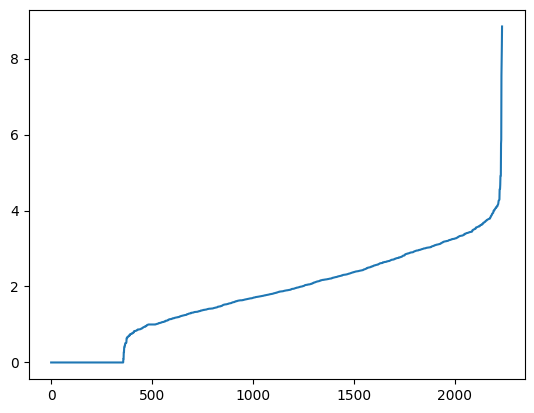

In [18]:
# Esto nos ayuda a ver la gráfica de rodilla y sacar los valores que se ubiquen en la curva
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

Búsqueda de epsilon y min_samples

In [19]:
# Se crean dos listas
eps_values = np.arange(0.25, 0.80, 0.10)
min_samples = np.arange(2, 10)

In [22]:
db_scan_params = list(product(eps_values, min_samples)) # Crea una lista con los eps y los min para luego iterar
sil_scores = [] # Lista vacía para guardar el coeficiente de silueta

for param in db_scan_params:
    y_pred = DBSCAN(eps=param[0], min_samples=param[1]).fit_predict(df_customer_preprocesado)
    etiquetas_y_pred = set(y_pred)

    if len(etiquetas_y_pred - {-1}) >= 2:
        score = silhouette_score(df_customer_preprocesado, y_pred)
    else:
        score = -1
    sil_scores.append(score)

In [23]:
df_params_tuning = pd.DataFrame.from_records(db_scan_params, columns=['Eps', 'Min_Samples']) # Crea un df de la lista db_scan_params
df_params_tuning['Sil_scores'] = sil_scores # Se agrega la lista que se alimentó con el for

In [24]:
# Creamos una matriz
pivot_data = pd.pivot_table(df_params_tuning, values='Sil_scores', index='Min_Samples', columns='Eps')

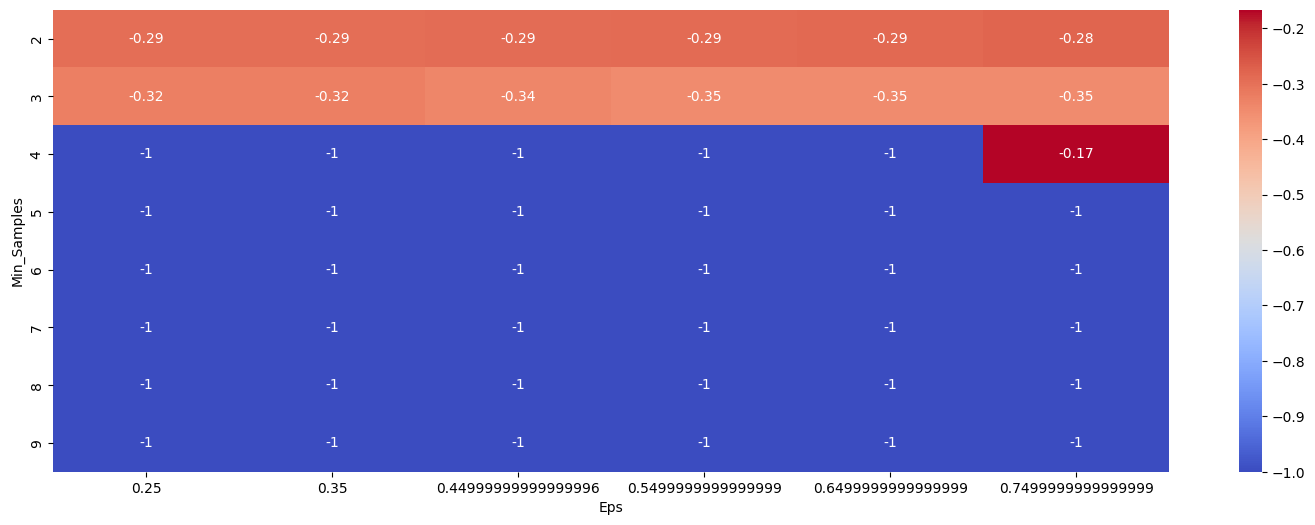

In [25]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(pivot_data, annot=True, annot_kws={'size':10}, cmap='coolwarm', ax=ax)
plt.show();

In [26]:
dbscan_cluster = DBSCAN(eps=0.75, min_samples=4) # Se tunea con los hiperparámetros encontrados anteriormente
y_predict_cluster = dbscan_cluster.fit_predict(df_customer_preprocesado)
df_customer['cluster'] = y_predict_cluster

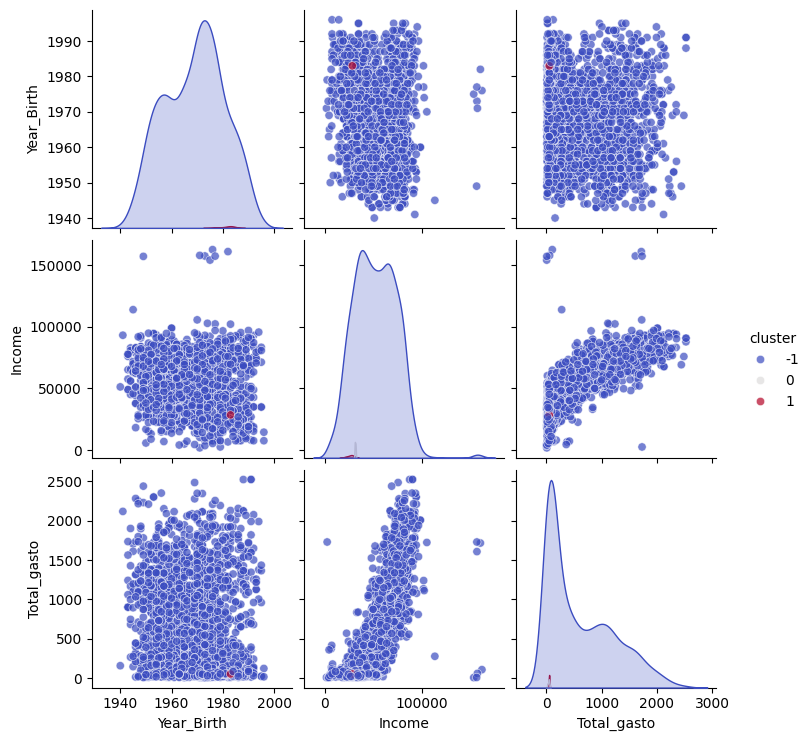

In [ ]:
# gráfica del modelo con algunas variables
sns.pairplot(df_customer[['Year_Birth', 'Income', 'Total_gasto', 'cluster']], hue='cluster', palette='coolwarm', plot_kws={'alpha':0.7 })
plt.show();

### Evaluación del modelo sin PCA

In [31]:
# Filtrar puntos que no son ruido
mask_no_ruido = y_predict_cluster != -1
x_no_ruido = df_customer_preprocesado[mask_no_ruido]
labels_no_ruido = y_predict_cluster[mask_no_ruido]

# Métrica 1: Silhouette Score (solo puntos no ruido)
if len(set(labels_no_ruido)) > 1:
    sil_score = silhouette_score(x_no_ruido, labels_no_ruido)
else:
    sil_score = None  # No se puede calcular si hay solo un clúster

# Métrica 2: Porcentaje de ruido
n_ruido = np.sum(y_predict_cluster == -1)
porcentaje_ruido = n_ruido / len(y_predict_cluster)

# Métrica 3: Número de clústeres detectados (excluyendo ruido)
n_clusters = len(set(y_predict_cluster)) - (1 if -1 in y_predict_cluster else 0)

# Métrica 4: Visualización (solo si hay 2 dimensiones)
if df_customer_preprocesado.shape[1] == 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_customer_preprocesado.iloc[:, 0], df_customer_preprocesado.iloc[:, 1],
                c=y_predict_cluster, cmap='tab10', s=50)
    plt.title(f"DBSCAN Clustering\nClusters: {n_clusters}, Ruido: {porcentaje_ruido:.2%}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

# Mostrar resultados
print(f"Número de clústeres detectados: {n_clusters}")
print(f"Porcentaje de puntos como ruido: {porcentaje_ruido:.2%}")
if sil_score is not None:
    print(f"Silhouette Score (sin ruido): {sil_score:.4f}")
else:
    print("No se puede calcular Silhouette Score (solo hay un clúster sin ruido)")


Número de clústeres detectados: 2
Porcentaje de puntos como ruido: 99.64%
Silhouette Score (sin ruido): 0.7001
